# Overview

This is a generalized notebook for computing grade statistics from the Ted Grade Center.

In [11]:
#The usual imports
from __future__ import division
import math
from collections import OrderedDict

from pandas import read_csv
import numpy as np

from pymatgen.util.plotting_utils import get_publication_quality_plot
from monty.string import remove_non_ascii

import prettyplotlib as ppl
from prettyplotlib import brewer2mpl
import matplotlib.pyplot as plt

colors = brewer2mpl.get_map('Set1', 'qualitative', 8).mpl_colors

%matplotlib inline

In [12]:
# Define lower grade cutoffs in terms of number of standard deviations from mean.
grade_cutoffs = OrderedDict()
#grade_cutoffs["A+"] = 1.5
#grade_cutoffs["A"] = 1
grade_cutoffs["A"] = 0.75
grade_cutoffs["B+"] = 0.5
grade_cutoffs["B"] = -0.25
grade_cutoffs["B-"] = -0.5
grade_cutoffs["C+"] = -0.75
grade_cutoffs["C"] = -1
grade_cutoffs["C-"] = -2
grade_cutoffs["F"] = float("-inf")

Load data from exported CSV from Ted Full Grade Center. Some sanitization is performed to remove non-ascii characters and cruft

In [13]:
def load_data(filename):
    d = read_csv(filename)
    d.columns = [remove_non_ascii(c) for c in d.columns]
    d.columns = [c.split("[")[0].strip().strip("\"") for c in d.columns]
    d["Weighted Total"] = [float(i.strip("%")) for i in d["Weighted Total"]]
    print(d.columns)
    return d

In [14]:
d = load_data("gc_CENG114_WI16_Ong_fullgc_2016-03-15-19-58-36.csv")

Index([u'Last Name', u'First Name', u'Username', u'Student ID', u'Last Access',
       u'Availability', u'Weighted Total', u'Total', u'SectionId', u'PS1',
       u'PS2', u'PS3', u'PS4', u'PS5', u'Midterm1', u'Midterm2', u'Final',
       u'WT'],
      dtype='object')


In [15]:
def bar_plot(dframe, data_key, offset=0):
    """
    Creates a historgram of the results.
    
    Args:
        dframe: DataFrame which is imported from CSV.
        data_key: Specific column to plot
        offset: Allows an offset for each grade. Defaults to 0.
        
    Returns:
        dict of cutoffs, {grade: (lower, upper)}
    """
    data = dframe[data_key]
    d = filter(lambda x: (not np.isnan(x)), list(data))
    N = len(d)
    print N
    heights, bins = np.histogram(d, bins=20, range=(0, 100))
    bins = list(bins)
    bins.pop(-1)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1)
    ppl.bar(ax, bins, heights, width=5, color=colors[0], grid='y')
    plt = get_publication_quality_plot(12, 8, plt)
    plt.xlabel("Score")
    plt.ylabel("Number of students")
    #print len([d for d in data if d > 90])
    mean = data.mean(0)
    sigma = data.std()
    maxy = np.max(heights)
    prev_cutoff = 100
    cutoffs = {}
    grade = ["A", "B+", "B", "B-", "C+", "C", "C-", "F"]
    for grade, cutoff in grade_cutoffs.items():
        if cutoff == float("-inf"):
            cutoff = 0
        else:
            cutoff = max(0, mean + cutoff * sigma) + offset
            plt.plot([cutoff] * 2, [0, maxy], 'k--')
            plt.annotate("%.1f" % cutoff, [cutoff, maxy - 1], fontsize=18, horizontalalignment='left', rotation=45)
        n = len([d for d in data if cutoff <= d < prev_cutoff])
        print "Grade %s (%.1f-%.1f): %d (%.2f%%)" % (grade, cutoff, prev_cutoff, n, n*1.0/N*100)
        plt.annotate(grade, [(cutoff + prev_cutoff) / 2, maxy], fontsize=18, horizontalalignment='center')
        cutoffs[grade] = (cutoff, prev_cutoff)
        prev_cutoff = cutoff
    
    plt.ylim([0, maxy * 1.1])
    plt.annotate("$\mu = %.1f$\n$\sigma = %.1f$\n$max=%.1f$" % (mean, sigma, data.max()), xy=(10, 7), fontsize=30)
    title = data_key.split("[")[0].strip()
    plt.title(title, fontsize=30)
    plt.tight_layout()
    plt.savefig("%s.png" % title)
    return cutoffs

PS1
191
Grade A (100.0-100.0): 0 (0.00%)
Grade B+ (100.0-100.0): 0 (0.00%)
Grade B (100.0-100.0): 0 (0.00%)
Grade B- (100.0-100.0): 0 (0.00%)
Grade C+ (100.0-100.0): 0 (0.00%)
Grade C (100.0-100.0): 0 (0.00%)
Grade C- (100.0-100.0): 0 (0.00%)
Grade F (0.0-100.0): 0 (0.00%)
PS2
191
Grade A (108.3-100.0): 0 (0.00%)
Grade B+ (103.5-108.3): 0 (0.00%)
Grade B (89.0-103.5): 171 (89.53%)
Grade B- (84.2-89.0): 0 (0.00%)
Grade C+ (79.3-84.2): 2 (1.05%)
Grade C (74.5-79.3): 0 (0.00%)
Grade C- (55.1-74.5): 7 (3.66%)
Grade F (0.0-55.1): 11 (5.76%)
PS3
191
Grade A (109.5-100.0): 0 (0.00%)
Grade B+ (104.3-109.5): 0 (0.00%)
Grade B (88.6-104.3): 174 (91.10%)
Grade B- (83.3-88.6): 1 (0.52%)
Grade C+ (78.1-83.3): 3 (1.57%)
Grade C (72.9-78.1): 0 (0.00%)
Grade C- (51.9-72.9): 3 (1.57%)
Grade F (0.0-51.9): 10 (5.24%)
PS4
191
Grade A (107.4-100.0): 0 (0.00%)
Grade B+ (101.6-107.4): 0 (0.00%)
Grade B (84.0-101.6): 160 (83.77%)
Grade B- (78.2-84.0): 4 (2.09%)
Grade C+ (72.4-78.2): 6 (3.14%)
Grade C (66.5-72

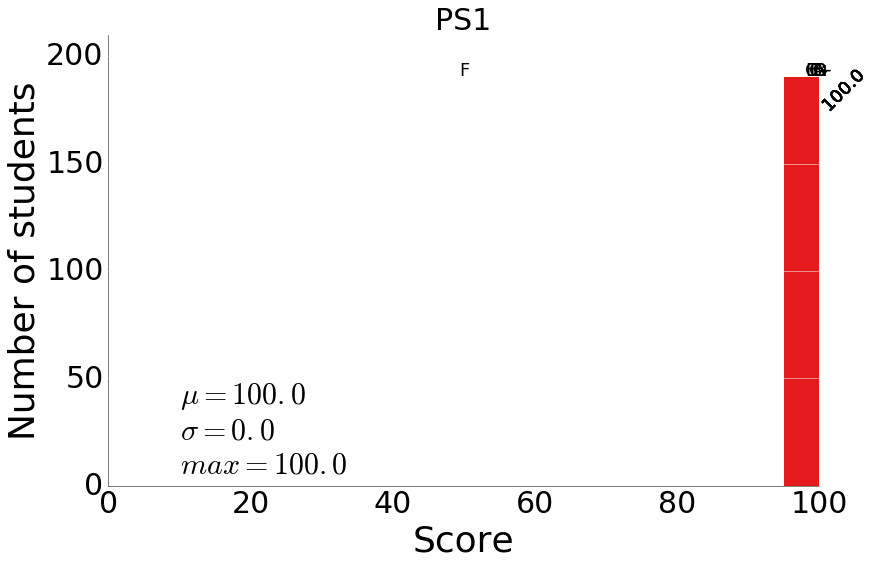

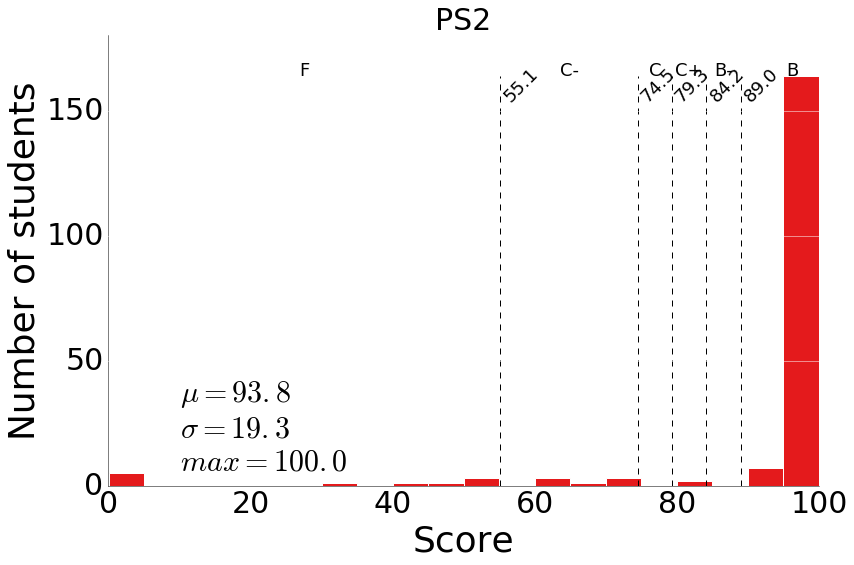

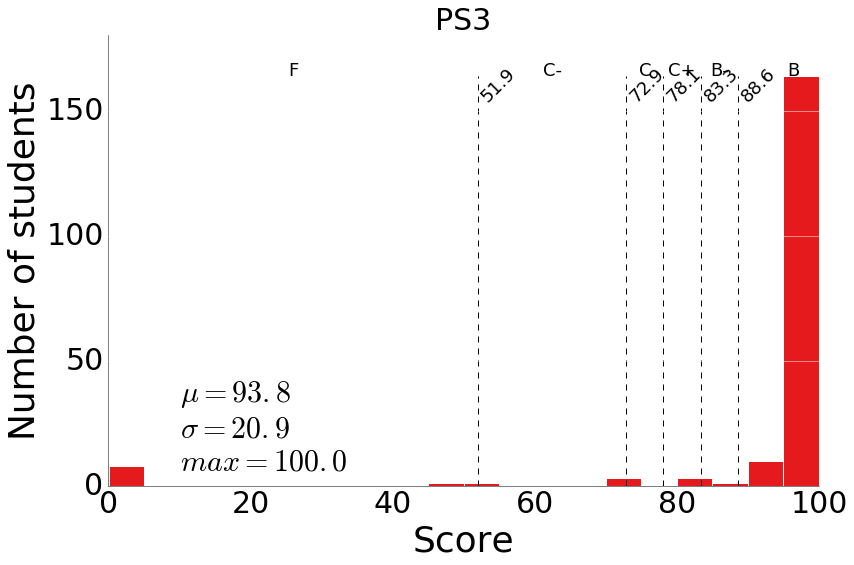

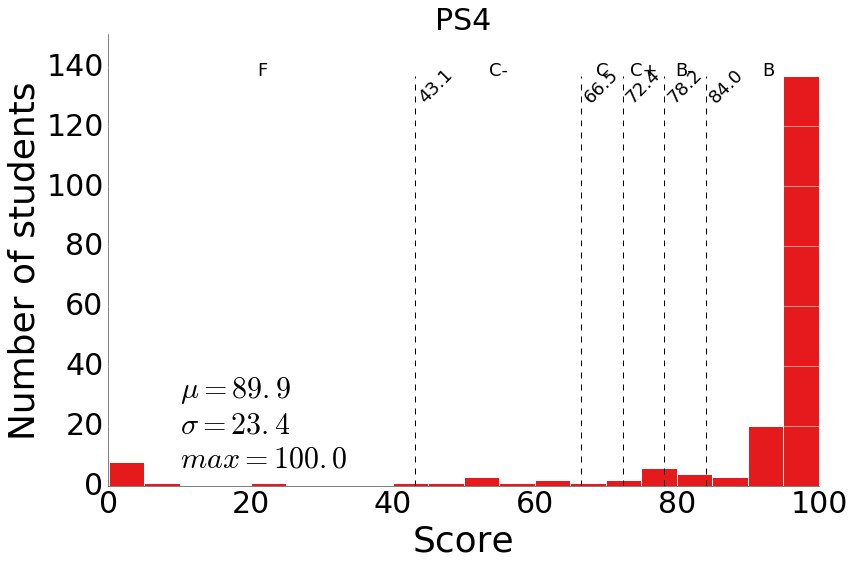

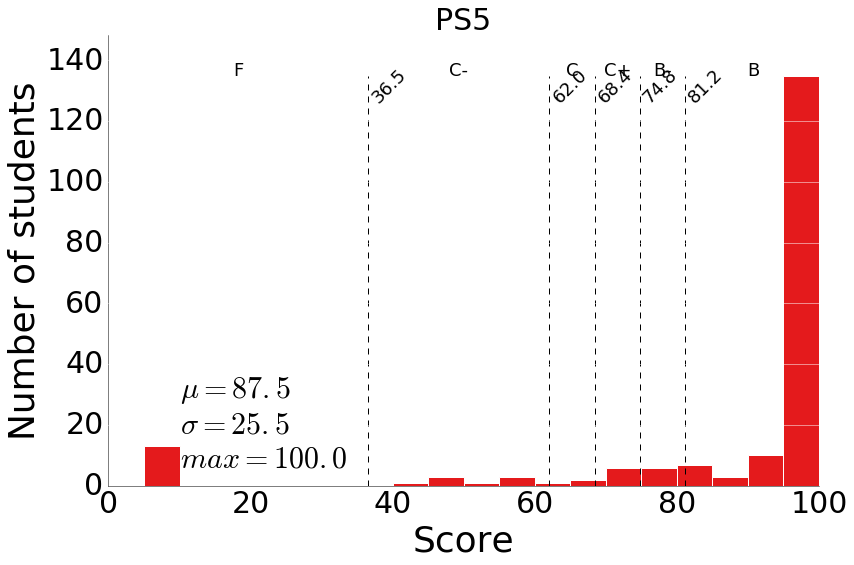

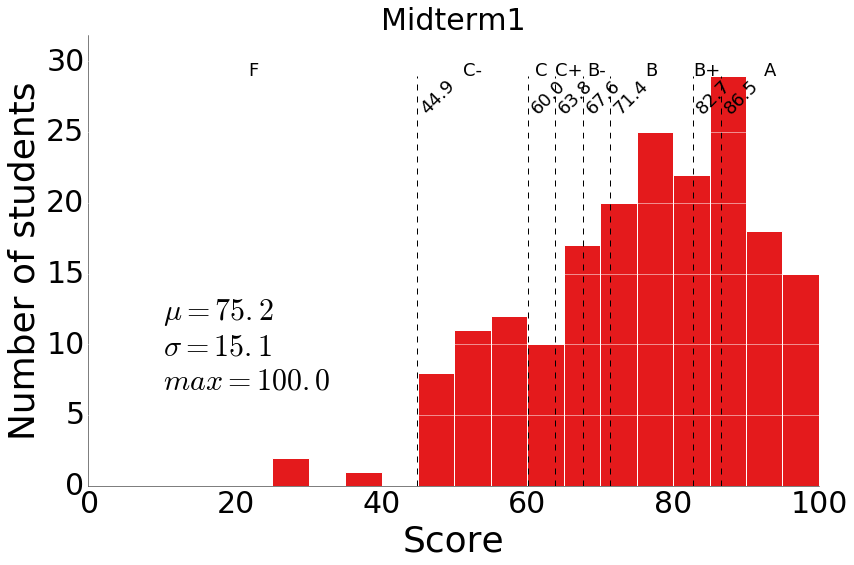

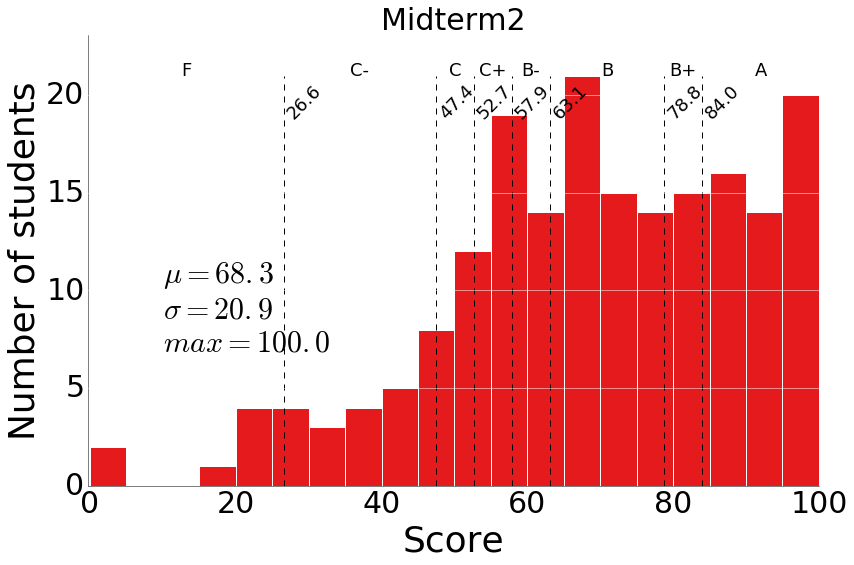

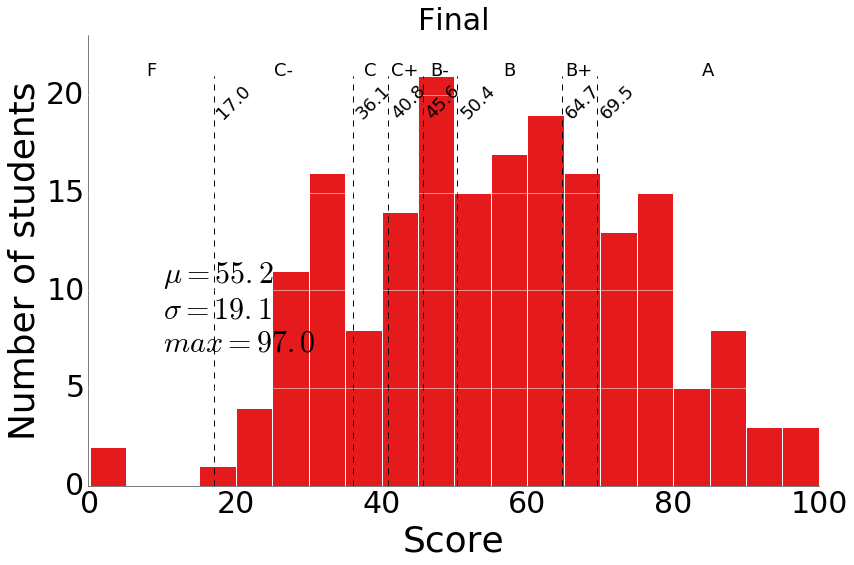

In [16]:
for c in d.columns:
    if "PS" in c or "Midterm" in c or "Final" in c:
        if not all(np.isnan(d[c])):
            print c
            bar_plot(d, c)

# Overall grade

Overall points and assign overall grade.

191
Grade A (77.8-100.0): 55 (28.80%)
Grade B+ (74.3-77.8): 17 (8.90%)
Grade B (63.9-74.3): 59 (30.89%)
Grade B- (60.4-63.9): 6 (3.14%)
Grade C+ (56.9-60.4): 14 (7.33%)
Grade C (53.4-56.9): 17 (8.90%)
Grade C- (39.4-53.4): 20 (10.47%)
Grade F (0.0-39.4): 3 (1.57%)


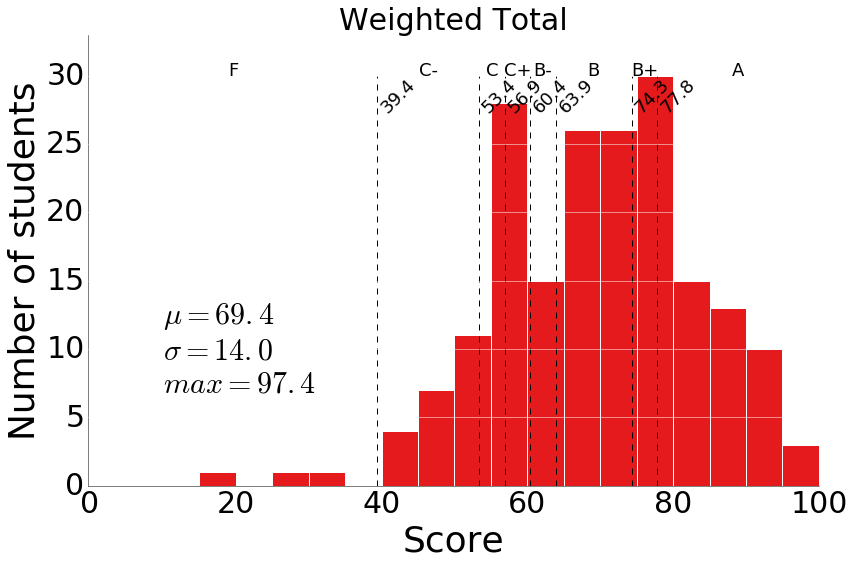

In [17]:
cutoffs = bar_plot(d, "Weighted Total", offset=-2)

In [18]:
print cutoffs

{'A': (77.829829749501982, 100), 'C+': (56.885981768822631, 60.376623098935859), 'C': (53.395340438709404, 56.885981768822631), 'B': (63.867264429049087, 74.339188419388762), 'C-': (39.432775118256501, 53.395340438709404), 'F': (0, 39.432775118256501), 'B-': (60.376623098935859, 63.867264429049087), 'B+': (74.339188419388762, 77.829829749501982)}


In [19]:
def assign_grade(pts):
    for g, c in cutoffs.items():
        if c[0] < pts <= c[1]:
            return g

#d = load_data("gc_CENG114_WI16_Ong_fullgc_2016-03-21-15-47-06.csv") #use revised gc
        
d["Final_Assigned_Egrade"] = map(assign_grade, d["Weighted Total"])
d.to_csv("Overall grades_OLD.csv")
print("Written!")

Written!
